In [1]:
import os
import sys
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

sys.path.append('.')
sys.path.append('../../')
sys.path.append('../network_model/')
sys.path.append('../validation/')

notebook_path = os.getcwd()
project_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_path)

from network_model.network_classes import Network
from networks_container import NetworksContainer
from estimator import Estimator

In [2]:
cherrypicked_seed = 42

seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

In [3]:
dataset_obama = pd.read_csv("../datasets/obamaAnonimized.csv", dtype=str)

In [4]:
endorsers_percentage_list = pd.read_csv("../datasets/obama_endorsers_hours_percentage_list.csv", dtype=int, header=None)
endorsers_percentage_list = endorsers_percentage_list.values.tolist()
endorsers_percentage_list = [item for sublist in endorsers_percentage_list for item in sublist]

In [5]:
print(len(endorsers_percentage_list))

4730


In [6]:
# Tolgo 1 in quanto considero la prima epoca come lo stato iniziale
epochs = len(endorsers_percentage_list) - 1

In [7]:
print(len(dataset_obama))

4337


In [8]:
n_nodes = 2678
n_nodes

2678

In [9]:
n_bots = round((1 / 100) * n_nodes)
n_bots

27

In [10]:
n_fact_checkers = round((1 / 100) * n_nodes)
n_fact_checkers

27

In [11]:
n_influencers = 29

In [12]:
n_commons = n_nodes - n_bots - n_fact_checkers - n_influencers
n_commons

2595

In [13]:
n_initial_infected_nodes = round((1 / 100) * n_nodes) - n_bots
n_initial_infected_nodes

0

In [14]:
# Prendo i parametri calibrati con un dataset diverso da quello usato per la validazione
parameters_df = pd.read_csv("../validation/parameters/parameters_optimization_palin_hours_homophily_0.50.csv")

In [15]:
parameters_df = parameters_df.sort_values(by='rmse')
parameters_df

,alpha,beta,homophily,prob_infection,prob_vaccination,prob_cure,prob_influencer,prob_echo,rmse
8,0.25,0.50,0.5,0.443859,0.098546,0.127511,0.941369,0.042834,2.061167
13,0.33,0.50,0.5,0.100720,0.029019,0.626069,0.359240,0.451349,3.733030
16,0.50,0.33,0.5,0.856125,0.187407,0.125657,0.702822,0.868028,3.921738
17,0.50,0.50,0.5,0.845530,0.419042,0.237069,0.896393,0.344756,5.846353
7,0.25,0.33,0.5,0.492750,0.005327,0.735202,0.805541,0.050565,8.436895
15,0.50,0.25,0.5,0.092425,0.386219,0.848022,0.999040,0.067329,9.511836
19,0.75,0.25,0.5,0.160062,0.484532,0.858237,0.878654,0.755461,11.697097
9,0.25,0.75,0.5,0.365273,0.504495,0.947275,0.941644,0.877097,11.747540
11,0.33,0.25,0.5,0.252417,0.061354,0.004153,0.993620,0.710981,12.297983
4,0.00,0.75,0.5,0.118196,0.163733,0.220993,0.913153,0.597945,16.072907


In [16]:
alpha = parameters_df['alpha'].iloc[0]
beta = parameters_df['beta'].iloc[0]
homophily = parameters_df['homophily'].iloc[0]
prob_infection = 0.0
prob_vaccination = parameters_df['prob_vaccination'].iloc[0]
prob_cure = parameters_df['prob_cure'].iloc[0]
prob_influencer = parameters_df['prob_influencer'].iloc[0]
prob_echo = parameters_df['prob_echo'].iloc[0]

In [17]:
container = NetworksContainer(n_networks=30, n_nodes=n_nodes, 
                              alpha=alpha, beta=beta, 
                              delta_in=1, delta_out=1, 
                              homophily=homophily, n_commons=n_commons, 
                              n_influencers=n_influencers, n_bots=n_bots, 
                              n_fact_checkers=n_fact_checkers,
                              prob_complaint=0.0, 
                              prob_infection=prob_infection, 
                              prob_vaccination=prob_vaccination,
                              prob_cure=prob_cure, 
                              prob_influencer=prob_influencer, 
                              exp_decay=True, user_block=False, 
                              prob_echo=prob_echo, epochs=epochs)
container.create_network_list(n_initial_infected_nodes=n_initial_infected_nodes)

In [18]:
total_y_pred_list_prob_000 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_prob_000.append(y_pred_list)

In [19]:
prob_infection = 0.25
container.set_probabilities(prob_influencer, prob_infection, prob_vaccination, prob_cure)

In [20]:
total_y_pred_list_prob_025 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_prob_025.append(y_pred_list)

In [21]:
prob_infection = 0.50
container.set_probabilities(prob_influencer, prob_infection, prob_vaccination, prob_cure)

In [22]:
total_y_pred_list_prob_050 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_prob_050.append(y_pred_list)

In [23]:
prob_infection = 0.75
container.set_probabilities(prob_influencer, prob_infection, prob_vaccination, prob_cure)

In [24]:
total_y_pred_list_prob_075 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_prob_075.append(y_pred_list)

In [25]:
prob_infection = 1.00
container.set_probabilities(prob_influencer, prob_infection, prob_vaccination, prob_cure)

In [26]:
total_y_pred_list_prob_100 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_prob_100.append(y_pred_list)

In [27]:
avg_y_pred_list_prob_000 = [sum(column) / len(column) for column in zip(*total_y_pred_list_prob_000)]
avg_y_pred_list_prob_025 = [sum(column) / len(column) for column in zip(*total_y_pred_list_prob_025)]
avg_y_pred_list_prob_050 = [sum(column) / len(column) for column in zip(*total_y_pred_list_prob_050)]
avg_y_pred_list_prob_075 = [sum(column) / len(column) for column in zip(*total_y_pred_list_prob_075)]
avg_y_pred_list_prob_100 = [sum(column) / len(column) for column in zip(*total_y_pred_list_prob_100)]

In [28]:
std_y_pred_list_prob_000 = [np.std(column) for column in zip(*total_y_pred_list_prob_000)]
std_y_pred_list_prob_025 = [np.std(column) for column in zip(*total_y_pred_list_prob_025)]
std_y_pred_list_prob_050 = [np.std(column) for column in zip(*total_y_pred_list_prob_050)]
std_y_pred_list_prob_075 = [np.std(column) for column in zip(*total_y_pred_list_prob_075)]
std_y_pred_list_prob_100 = [np.std(column) for column in zip(*total_y_pred_list_prob_100)]

In [29]:
std_low_y_pred_list_prob_000 = []
std_high_y_pred_list_prob_000 = []
std_low_y_pred_list_prob_025 = []
std_high_y_pred_list_prob_025 = []
std_low_y_pred_list_prob_050 = []
std_high_y_pred_list_prob_050 = []
std_low_y_pred_list_prob_075 = []
std_high_y_pred_list_prob_075 = []
std_low_y_pred_list_prob_100 = []
std_high_y_pred_list_prob_100 = []

for i in range(len(avg_y_pred_list_prob_000)):
    std_low_y_pred_list_prob_000.append(avg_y_pred_list_prob_000[i] - std_y_pred_list_prob_000[i])
    std_high_y_pred_list_prob_000.append(avg_y_pred_list_prob_000[i] + std_y_pred_list_prob_000[i])

for i in range(len(avg_y_pred_list_prob_025)):
    std_low_y_pred_list_prob_025.append(avg_y_pred_list_prob_025[i] - std_y_pred_list_prob_025[i])
    std_high_y_pred_list_prob_025.append(avg_y_pred_list_prob_025[i] + std_y_pred_list_prob_025[i])

for i in range(len(avg_y_pred_list_prob_050)):
    std_low_y_pred_list_prob_050.append(avg_y_pred_list_prob_050[i] - std_y_pred_list_prob_050[i])
    std_high_y_pred_list_prob_050.append(avg_y_pred_list_prob_050[i] + std_y_pred_list_prob_050[i])

for i in range(len(avg_y_pred_list_prob_075)):
    std_low_y_pred_list_prob_075.append(avg_y_pred_list_prob_075[i] - std_y_pred_list_prob_075[i])
    std_high_y_pred_list_prob_075.append(avg_y_pred_list_prob_075[i] + std_y_pred_list_prob_075[i])

for i in range(len(avg_y_pred_list_prob_100)):
    std_low_y_pred_list_prob_100.append(avg_y_pred_list_prob_100[i] - std_y_pred_list_prob_100[i])
    std_high_y_pred_list_prob_100.append(avg_y_pred_list_prob_100[i] + std_y_pred_list_prob_100[i])

In [30]:
x = []
for i in range(len(endorsers_percentage_list)):
    x.append(i)

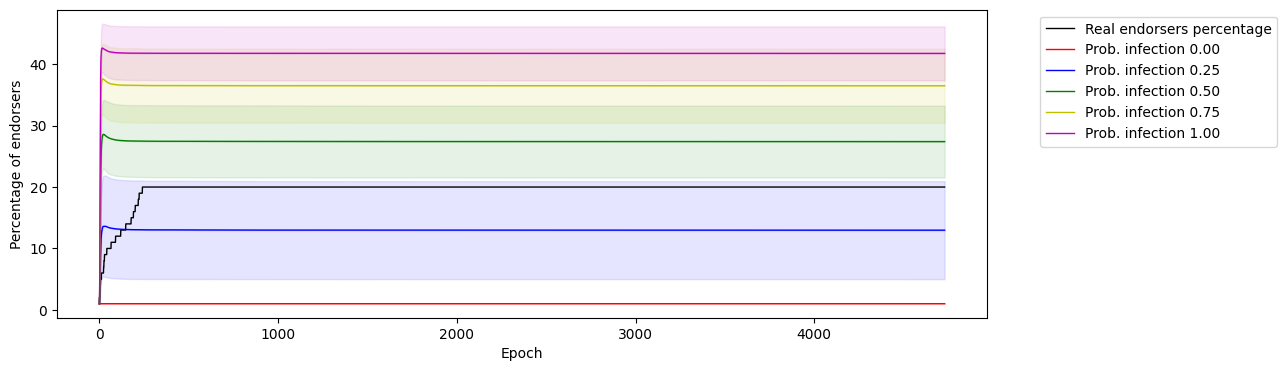

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(endorsers_percentage_list, c='k', label='Real endorsers percentage', linewidth=1.0)
plt.plot(avg_y_pred_list_prob_000, c='r', label='Prob. infection 0.00', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_000, std_low_y_pred_list_prob_000, color='r', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_000, std_high_y_pred_list_prob_000, color='r', alpha=.1)
plt.plot(avg_y_pred_list_prob_025, c='b', label='Prob. infection 0.25', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_025, std_low_y_pred_list_prob_025, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_025, std_high_y_pred_list_prob_025, color='b', alpha=.1)
plt.plot(avg_y_pred_list_prob_050, c='g', label='Prob. infection 0.50', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_050, std_low_y_pred_list_prob_050, color='g', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_050, std_high_y_pred_list_prob_050, color='g', alpha=.1)
plt.plot(avg_y_pred_list_prob_075, c='y', label='Prob. infection 0.75', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_075, std_low_y_pred_list_prob_075, color='y', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_075, std_high_y_pred_list_prob_075, color='y', alpha=.1)
plt.plot(avg_y_pred_list_prob_100, c='m', label='Prob. infection 1.00', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_100, std_low_y_pred_list_prob_100, color='m', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_100, std_high_y_pred_list_prob_100, color='m', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [32]:
x = []
endorsers_percentage_list_truncated = []
avg_y_pred_list_prob_000_truncated = []
std_low_y_pred_list_prob_000_truncated = []
std_high_y_pred_list_prob_000_truncated = []
avg_y_pred_list_prob_025_truncated = []
std_low_y_pred_list_prob_025_truncated = []
std_high_y_pred_list_prob_025_truncated = []
avg_y_pred_list_prob_050_truncated = []
std_low_y_pred_list_prob_050_truncated = []
std_high_y_pred_list_prob_050_truncated = []
avg_y_pred_list_prob_075_truncated = []
std_low_y_pred_list_prob_075_truncated = []
std_high_y_pred_list_prob_075_truncated = []
avg_y_pred_list_prob_100_truncated = []
std_low_y_pred_list_prob_100_truncated = []
std_high_y_pred_list_prob_100_truncated = []
for i in range(500):
    x.append(i)
    endorsers_percentage_list_truncated.append(endorsers_percentage_list[i])
    avg_y_pred_list_prob_000_truncated.append(avg_y_pred_list_prob_000[i])
    std_low_y_pred_list_prob_000_truncated.append(std_low_y_pred_list_prob_000[i])
    std_high_y_pred_list_prob_000_truncated.append(std_high_y_pred_list_prob_000[i])
    avg_y_pred_list_prob_025_truncated.append(avg_y_pred_list_prob_025[i])
    std_low_y_pred_list_prob_025_truncated.append(std_low_y_pred_list_prob_025[i])
    std_high_y_pred_list_prob_025_truncated.append(std_high_y_pred_list_prob_025[i])
    avg_y_pred_list_prob_050_truncated.append(avg_y_pred_list_prob_050[i])
    std_low_y_pred_list_prob_050_truncated.append(std_low_y_pred_list_prob_050[i])
    std_high_y_pred_list_prob_050_truncated.append(std_high_y_pred_list_prob_050[i])
    avg_y_pred_list_prob_075_truncated.append(avg_y_pred_list_prob_075[i])
    std_low_y_pred_list_prob_075_truncated.append(std_low_y_pred_list_prob_075[i])
    std_high_y_pred_list_prob_075_truncated.append(std_high_y_pred_list_prob_075[i])
    avg_y_pred_list_prob_100_truncated.append(avg_y_pred_list_prob_100[i])
    std_low_y_pred_list_prob_100_truncated.append(std_low_y_pred_list_prob_100[i])
    std_high_y_pred_list_prob_100_truncated.append(std_high_y_pred_list_prob_100[i])

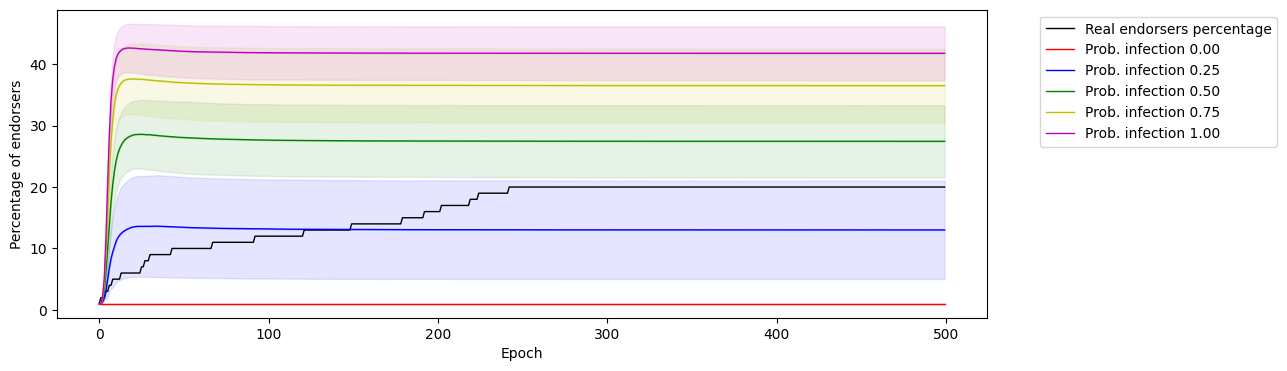

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(endorsers_percentage_list_truncated, c='k', label='Real endorsers percentage', linewidth=1.0)
plt.plot(avg_y_pred_list_prob_000_truncated, c='r', label='Prob. infection 0.00', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_000_truncated, std_low_y_pred_list_prob_000_truncated, color='r', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_000_truncated, std_high_y_pred_list_prob_000_truncated, color='r', alpha=.1)
plt.plot(avg_y_pred_list_prob_025_truncated, c='b', label='Prob. infection 0.25', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_025_truncated, std_low_y_pred_list_prob_025_truncated, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_025_truncated, std_high_y_pred_list_prob_025_truncated, color='b', alpha=.1)
plt.plot(avg_y_pred_list_prob_050_truncated, c='g', label='Prob. infection 0.50', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_050_truncated, std_low_y_pred_list_prob_050_truncated, color='g', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_050_truncated, std_high_y_pred_list_prob_050_truncated, color='g', alpha=.1)
plt.plot(avg_y_pred_list_prob_075_truncated, c='y', label='Prob. infection 0.75', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_075_truncated, std_low_y_pred_list_prob_075_truncated, color='y', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_075_truncated, std_high_y_pred_list_prob_075_truncated, color='y', alpha=.1)
plt.plot(avg_y_pred_list_prob_100_truncated, c='m', label='Prob. infection 1.00', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_100_truncated, std_low_y_pred_list_prob_100_truncated, color='m', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_100_truncated, std_high_y_pred_list_prob_100_truncated, color='m', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [34]:
y_true = endorsers_percentage_list

neg_rmse_list_prob_000 = []
neg_rmse_list_prob_025 = []
neg_rmse_list_prob_050 = []
neg_rmse_list_prob_075 = []
neg_rmse_list_prob_100 = []

for i in range(container.n_networks):
        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_prob_000[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_prob_000.append(neg_rmse)

        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_prob_025[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_prob_025.append(neg_rmse)

        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_prob_050[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_prob_050.append(neg_rmse)

        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_prob_075[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_prob_075.append(neg_rmse)

        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_prob_100[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_prob_100.append(neg_rmse)
    
mean_neg_rmse_prob_000 = np.mean(neg_rmse_list_prob_000)
std_neg_rmse_prob_000 = np.std(neg_rmse_list_prob_000)
mean_neg_rmse_prob_025 = np.mean(neg_rmse_list_prob_025)
std_neg_rmse_prob_025 = np.std(neg_rmse_list_prob_025)
mean_neg_rmse_prob_050 = np.mean(neg_rmse_list_prob_050)
std_neg_rmse_prob_050 = np.std(neg_rmse_list_prob_050)
mean_neg_rmse_prob_075 = np.mean(neg_rmse_list_prob_075)
std_neg_rmse_prob_075 = np.std(neg_rmse_list_prob_075)
mean_neg_rmse_prob_100 = np.mean(neg_rmse_list_prob_100)
std_neg_rmse_prob_100 = np.std(neg_rmse_list_prob_100)

In [35]:
print("Mean 0.00: ", mean_neg_rmse_prob_000)
print("Standard deviation 0.00: ", std_neg_rmse_prob_000)

Mean 0.00:  -18.69791023425294
Standard deviation 0.00:  3.552713678800501e-15


In [36]:
print("Mean 0.25: ", mean_neg_rmse_prob_025)
print("Standard deviation 0.25: ", std_neg_rmse_prob_025)

Mean 0.25:  -8.674190690370157
Standard deviation 0.25:  5.975724746071419


In [37]:
print("Mean 0.50: ", mean_neg_rmse_prob_050)
print("Standard deviation 0.50: ", std_neg_rmse_prob_050)

Mean 0.50:  -9.075688844716831
Standard deviation 0.50:  3.968175025786645


In [38]:
print("Mean 0.75: ", mean_neg_rmse_prob_075)
print("Standard deviation 0.75: ", std_neg_rmse_prob_075)

Mean 0.75:  -17.137163466556768
Standard deviation 0.75:  5.498333619825659


In [39]:
print("Mean 1.00: ", mean_neg_rmse_prob_100)
print("Standard deviation 1.00: ", std_neg_rmse_prob_100)

Mean 1.00:  -22.20246414023578
Standard deviation 1.00:  4.354602961199614


In [40]:
df_total_y_pred_list_000 = pd.DataFrame(total_y_pred_list_prob_000).T
df_total_y_pred_list_000.to_csv("sensitivity_infection_0.00_obama_endorsers_percentages.csv", index=False, header=False)

df_total_y_pred_list_025 = pd.DataFrame(total_y_pred_list_prob_025).T
df_total_y_pred_list_025.to_csv("sensitivity_infection_0.25_obama_endorsers_percentages.csv", index=False, header=False)

df_total_y_pred_list_050 = pd.DataFrame(total_y_pred_list_prob_050).T
df_total_y_pred_list_050.to_csv("sensitivity_infection_0.50_obama_endorsers_percentages.csv", index=False, header=False)

df_total_y_pred_list_075 = pd.DataFrame(total_y_pred_list_prob_075).T
df_total_y_pred_list_075.to_csv("sensitivity_infection_0.75_obama_endorsers_percentages.csv", index=False, header=False)

df_total_y_pred_list_100 = pd.DataFrame(total_y_pred_list_prob_100).T
df_total_y_pred_list_100.to_csv("sensitivity_infection_1.00_obama_endorsers_percentages.csv", index=False, header=False)

In [41]:
df_statistics = pd.DataFrame(avg_y_pred_list_prob_000).T
df_statistics.loc[1] = std_y_pred_list_prob_000
df_statistics.loc[2] = std_high_y_pred_list_prob_000
df_statistics.loc[3] = std_low_y_pred_list_prob_000
df_statistics.loc[4] = avg_y_pred_list_prob_025
df_statistics.loc[5] = std_y_pred_list_prob_025
df_statistics.loc[6] = std_high_y_pred_list_prob_025
df_statistics.loc[7] = std_low_y_pred_list_prob_025
df_statistics.loc[8] = avg_y_pred_list_prob_050
df_statistics.loc[9] = std_y_pred_list_prob_050
df_statistics.loc[10] = std_high_y_pred_list_prob_050
df_statistics.loc[11] = std_low_y_pred_list_prob_050
df_statistics.loc[12] = avg_y_pred_list_prob_075
df_statistics.loc[13] = std_y_pred_list_prob_075
df_statistics.loc[14] = std_high_y_pred_list_prob_075
df_statistics.loc[15] = std_low_y_pred_list_prob_075
df_statistics.loc[16] = avg_y_pred_list_prob_100
df_statistics.loc[17] = std_y_pred_list_prob_100
df_statistics.loc[18] = std_high_y_pred_list_prob_100
df_statistics.loc[19] = std_low_y_pred_list_prob_100
df_statistics.to_csv("sensitivity_infection_obama_statistics.csv", index=False, header=False)

In [42]:
df_sensitivity_rmse = pd.DataFrame(neg_rmse_list_prob_000).T
df_sensitivity_rmse.loc[1] = neg_rmse_list_prob_025
df_sensitivity_rmse.loc[2] = neg_rmse_list_prob_050
df_sensitivity_rmse.loc[3] = neg_rmse_list_prob_075
df_sensitivity_rmse.loc[4] = neg_rmse_list_prob_100
df_sensitivity_rmse.to_csv("sensitivity_infection_obama_rmse.csv", index=False, header=False)